In [1]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
train_dataset = MNIST(download=True, root='data', train=True, transform=ToTensor())
train_data = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = MNIST(download=True, root='data', train=False, transform=ToTensor())
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False)


/opt/homebrew/Caskroom/miniforge/base/envs/bachelor-project/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217266490/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [177]:
def sigmoid(x, deriv=False):
  out = 1.0 / (1.0 + np.exp(-x))
  if deriv:
    return out * (1 - out)
  return out

def leaky_relu(x, deriv=False):
  factor = ((x > 0) + 0.1)
  if deriv:
    return factor
  return factor * x


def onehot(x):
  return np.eye(10)[x]

ir = 5e-1 # Inference rate
lr = 1e-2 # Learning rate

def get_weights_and_biases(in_features, out_features):
  w = np.random.randn(out_features, in_features) *  2/np.sqrt(in_features)
  b = np.zeros(out_features)

  return w, b

# Define out layer sizes
in_features = 784
hidden_features = 256
out_features = 10

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden_features)
W2, b2 = get_weights_and_biases(hidden_features, out_features)

loss_history = []
activation1 = leaky_relu
activation2 = sigmoid

for epoch in range(5):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    x0 = images.flatten(start_dim=1).numpy()
    x1 = np.zeros((x0.shape[0], hidden_features))
    x2 = np.zeros((x0.shape[0], out_features))
    x3 = onehot(labels) # Constrain output to be the correct labels.

    x3_pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2)

    loss = ((x3 - x3_pred) ** 2).mean() # MSE loss
    tqdm_train_data.set_description(f"Loss: {loss}")
    loss_history.append(loss)
    errors_history = []

    # Run predictive coding inference. 
    for t in range(20):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2)

      # Calculate errors
      e1 = x1 - u1
      e2 = x2 - u2
      e3 = x3 - u3

      # Canculate derivatives
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      dx2 = -e2 + activation2(x2, deriv=True) * e3
      #dx3 = -e3 # Only do this during inference

      # Do actual steps
      x1 += ir * dx1
      x2 += ir * dx2
      #x3 -= ir * dx3 # Only do this during inference.

      #errors_history.append(((e1 ** 2).mean(), (e2 ** 2).mean()))

    error_histories = zip(*errors_history)
    for error_history in error_histories:
      plt.plot(error_history)
      plt.show()

    #break
      
    # Perform weight update here.
    dW1 = e1[:, :, None] @ activation1(x0)[:, None, :]
    dW2 = e2[:, :, None] @ activation2(x1)[:, None, :]

    W1 += lr * dW1.mean(axis=0)
    W2 += lr * dW2.mean(axis=0)
  #break

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

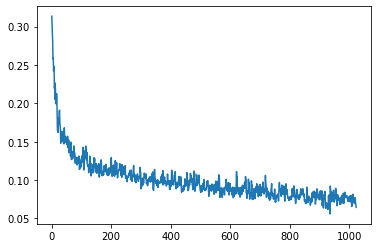

In [87]:
plt.plot(loss_history)
plt.show()

In [180]:
tested = 0
correct = 0

for images, labels in test_data:
  x0 = images.flatten(start_dim=1).numpy()
  x3_pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2)
  pred_labels = np.argmax(x3_pred, axis=1)
  tested += len(pred_labels)
  correct += (pred_labels == labels.numpy()).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 73.95%


In [89]:
import torch
import torch.nn.functional as F

In [226]:
def sigmoid(x, deriv=False):
  out = F.sigmoid(x)
  if deriv:
    return out * (1 - out)
  return out

def leaky_relu(x, deriv=False):
  factor = (x > 0) + 0.1
  if deriv:
    return factor
  return factor * x


def softmax(x, deriv=False):
  if deriv:
    return torch.ones_like(x)
  return x.exp() / x.exp().sum(dim=1, keepdim=True)

def onehot(x):
  return torch.eye(10)[x]

In [263]:
ir = 1e-1 # Inference rate
lr = 1e-1 # Learning rate

test = False

def get_weights_and_biases(in_features, out_features):
  W = torch.randn((out_features, in_features)) * 2/np.sqrt(in_features)
  b = torch.zeros(out_features)

  return W, b

# Define out layer sizes
in_features = 784
hidden1_features = 600
hidden2_features = 600
out_features = 10

# Define weights and biases
#W1, b1 = get_weights_and_biases(in_features, hidden1_features)
#W2, b2 = get_weights_and_biases(hidden1_features, hidden2_features)
#W3, b3 = get_weights_and_biases(hidden2_features, out_features)

#loss_history = []
activation1 = leaky_relu
activation2 = leaky_relu
activation3 = softmax

for epoch in range(5):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    x0 = images.flatten(start_dim=1)
    batch_dim = x0.shape[0]
    x1 = torch.zeros((batch_dim, hidden1_features))
    v1 = torch.zeros((hidden1_features))

    x2 = torch.zeros((batch_dim, hidden2_features))
    v2 = torch.zeros((hidden2_features))

    x3 = torch.zeros((batch_dim, out_features))
    v3 = torch.zeros((out_features))

    x4 = onehot(labels) # Constrain output to be the correct labels.

    x4_pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)

    

    #loss = -(torch.log(x4_pred) * x4 + (1-x4) * torch.log(1-x4_pred)).mean() # Cross entropy loss
    loss = -(torch.log(x4_pred) * x4).mean() # Cross entropy loss
    tqdm_train_data.set_description(f"Loss: {loss}")
    loss_history.append(loss)
    errors_history = []

    # Run predictive coding inference. 
    for t in range(200):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2) @ W3.T + b3
      u4 = activation3(x3)

      # Calculate errors
      e1 = x1 - u1
      e2 = x2 - u2
      e3 = x3 - u3
      e4 = x4 - u4

      # Canculate derivatives
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      dx3 = -e3 + activation3(x3, deriv=True) * (e4)
      #dx4 = -e4 # Only do this during inference

      # Do actual steps
      x1 += ir * dx1
      x2 += ir * dx2
      x3 += ir * dx3
      #x4 -= ir * dx4 # Only do this during inference.

      if test:
        errors_history.append(((e1 ** 2).mean(), (e2 ** 2).mean(), (e3 ** 2).mean(), (e4 ** 2).mean()))

    error_histories = zip(*errors_history)
    for error_history in error_histories:
      plt.plot(error_history)
      plt.show()
      
    if test:
      break
    # Calculate gradients
    dW1 = e1[:, :, None] @ activation1(x0)[:, None, :]
    dW2 = e2[:, :, None] @ activation2(x1)[:, None, :]
    dW3 = e3[:, :, None] @ activation3(x2)[:, None, :]

    db1 = e1
    db2 = e2
    db3 = e3

    #print(dW1, dW2)

    # Perform weight update here.
    W1 += lr * dW1.mean(dim=0)
    b1 += lr * db1.mean(dim=0)

    W2 += lr * dW2.mean(dim=0)
    b2 += lr * db2.mean(dim=0)

    W3 += lr * dW3.mean(dim=0)
    b3 += lr * db3.mean(dim=0)

  if test:
    break

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

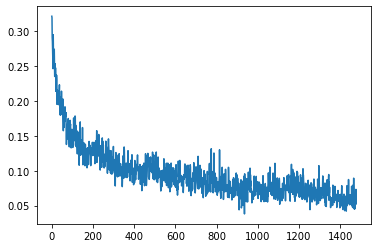

In [264]:
plt.plot(loss_history)
plt.show()

In [265]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  x3_pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
  pred_labels = x3_pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 89.2300033569336%


In [244]:
import torch.nn as nn

In [267]:

class MLP(nn.Module):
  def __init__(self, in_features, hidden1_features, hidden2_features, out_features):
    super().__init__()
    self.l1 = nn.Linear(in_features, hidden1_features)
    self.l2 = nn.Linear(hidden1_features, hidden2_features)
    self.l3 = nn.Linear(hidden2_features, out_features)

  def forward(self, x):
    x = activation1(self.l1(x))
    x = activation2(self.l2(x))
    x = activation3(self.l3(x))
    return x


model = MLP(in_features, hidden1_features, hidden2_features, out_features)



In [268]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [269]:
for epoch in range(5):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    optimizer.zero_grad()
    x0 = images.flatten(start_dim=1)

    pred = model(x0)
    loss = criterion(pred, labels)
    loss.backward()

    tqdm_train_data.set_description(f"Loss: {loss.item()}")

    optimizer.step()



Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [270]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  x3_pred = model(x0)
  pred_labels = x3_pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 85.25999450683594%
